In [ ]:
# Copyright 2025, Jan N. Hansen, https://github.com/hansenjn
# If you reuse the code (in particular the nucleus - cilia - assignment strategy), consider citing https://www.biorxiv.org/content/10.1101/2024.10.20.619273

# %% 
# Import packages
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
from scipy.stats import kruskal
import scikit_posthocs as sp
from statannotations.Annotator import Annotator

In [ ]:
# Define repository path
datapath = 'E:\\HPA_CILIA_STUDY\\'

In [ ]:
# Name analyzed gene
gene = "CKAP2"

In [ ]:
# Import files

# Import GMNN prediction file, listing nucleus coordinates and predicted GMNN intensity in nucleus
GMNN_predict = pd.read_csv(os.path.join(datapath,"InputFiles", "CKAP2_GMNN-Prediction.csv"))
GMNN_predict.columns = GMNN_predict.columns.str.lstrip()
GMNN_predict.rename(columns={"file_name": "img_index"}, inplace=True)
GMNN_predict.rename(columns={"# predicted": "GMNN_intensity"}, inplace=True)

# Since x and y are defined in python differently than in CiliaQ we swap x and y in the GMNN prediction table
GMNN_predict.rename(columns={"x": "y_new"}, inplace=True)
GMNN_predict.rename(columns={"y": "GMNN_x"}, inplace=True)
GMNN_predict.rename(columns={"y_new": "GMNN_y"}, inplace=True)

# Shorten filenames (remove unnecessary information):
GMNN_predict["img_index"] = GMNN_predict["img_index"].str.replace("_new_stack$", "", regex=True)

# Loading CiliaQ text file (this is a concatenation of the column header and the individual CQs.txt output files)
ciliaq = pd.read_csv(os.path.join(datapath,"InputFiles", "CiliaQ_Combined.txt"),
                     sep='\t',
                     na_values=['', ' '],
                     keep_default_na=True)

# Shorten filenames (remove unnecessary information) and rename columns to match style between ciliaq and GMNN_predict lists:
ciliaq["File name"] = ciliaq["File name"].str.removesuffix("_new_stack_PRE_CQP.tif")
ciliaq.rename(columns={"File name": "img_index"}, inplace=True)

# Compute basal body coordinates in pixel to match unit in GMNN_predict
ciliaq['bb_x'] = ciliaq['basalbody x center [micron]']/0.070694
ciliaq['bb_y'] = ciliaq['basalbody y center [micron]']/0.070694

In [ ]:
# Exploring columns
print('Max x GMNN:  ' + str(max(GMNN_predict['GMNN_x'])))
print('Max y GMNN:  ' + str(max(GMNN_predict['GMNN_y'])))
print('Max bb x ciliaq:  ' + str(max(ciliaq['bb_x'])))
print('Max bb y ciliaq:  ' + str(max(ciliaq['bb_y'])))

Max x GMNN:  2039.2070621737064
Max y GMNN:  2039.9785946486625
Max bb x ciliaq:  2044.126220046963
Max bb y ciliaq:  2044.9466574249582


In [ ]:
# Drop note columns (the last 4 columns in the CQS.txt contain notes or are empty)
# In the concatenated file we had named the columns Note1, Note2, etc. to avoid empty column names
ciliaq = ciliaq.drop(columns=["Note1", "Note2", "Note3", "Note4"], errors="ignore")

In [ ]:
# Assign basal bodies to nuclei

MAX_DIST_NNUCLEI_CILIA = 250
assignments = 0
totalCells = len(GMNN_predict["GMNN_x"])

grouped_GMNN_predict = GMNN_predict.groupby("img_index")
for img_id, GMNN_predict_group in grouped_GMNN_predict: 
    # Extract only the ciliaq rows for this img_id 
    ciliaq_chunk = ciliaq[ciliaq["img_index"] == img_id]

    #Convert to a NumPy array (shape = [num_rows, 2]):
    subcell_points = GMNN_predict_group[['GMNN_x',
                                    'GMNN_y']].values
    ciliaq_points = ciliaq_chunk[['bb_x',
                                  'bb_y']].values

    distance_matrix = cdist(subcell_points, ciliaq_points, 'euclidean')

    # Reset all distances above 5 so distances above 5 do not influence assignment
    distance_matrix = np.where(distance_matrix>MAX_DIST_NNUCLEI_CILIA, MAX_DIST_NNUCLEI_CILIA, distance_matrix)
    
    # Square the distances to force assignments of smaller distances over larger distances (penalizes "long" distance assignments)
    distance_matrix = np.square(distance_matrix)
    
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    
    # IMPORTANT: Reset index but keep the old index as a column
    # so we know how to write back to the main subcell DataFrame
    GMNN_predict_group_temp = GMNN_predict_group.reset_index() # old index is in GMNN_predict_group_temp["index"]
    ciliaq_chunk_temp = ciliaq_chunk.reset_index() # old index is in ciliaq_chunk_temp["index"]
    
    # Do the assignment 
    for i in range(len(row_ind)):
        assignments += 1
        GMNN_predict_idx = row_ind[i]
        ciliaq_idx = col_ind[i]
        # Retrieve the “true” DataFrame indices from the temp frames 
        sub_idx_in_main = GMNN_predict_group_temp.loc[GMNN_predict_idx, "index"]
        ciliaq_idx_in_main = ciliaq_chunk_temp.loc[ciliaq_idx, "index"]
        # Copy the columns 
        for col in ciliaq.columns: 
            GMNN_predict.loc[sub_idx_in_main, "CILIAQ_" + col] = ciliaq.loc[ciliaq_idx_in_main, col] # For unmatched subcell rows or GMNN rows, do np.nan or other logic as needed
        GMNN_predict.loc[sub_idx_in_main, "bb_nucleus_distance"] = np.sqrt( (GMNN_predict.loc[sub_idx_in_main, "GMNN_x"] - ciliaq.loc[ciliaq_idx_in_main, "bb_x"])**2 + (GMNN_predict.loc[sub_idx_in_main, "GMNN_y"] - ciliaq.loc[ciliaq_idx_in_main, "bb_y"])**2 )
        GMNN_predict.loc[sub_idx_in_main, "assignment_cost"] = distance_matrix[row_ind[i], col_ind[i]]

print('In total ' + str(assignments) + ' nuclei were matched (of ' 
      + str(len(ciliaq['basalbody x center [micron]'])) + ' BBs in ciliaq data and '
      + str(totalCells) + ' nuclei in GMNN_predict)')

In total 92 nuclei were matched (of 192 BBs in ciliaq data and 92 nuclei in GMNN_predict)


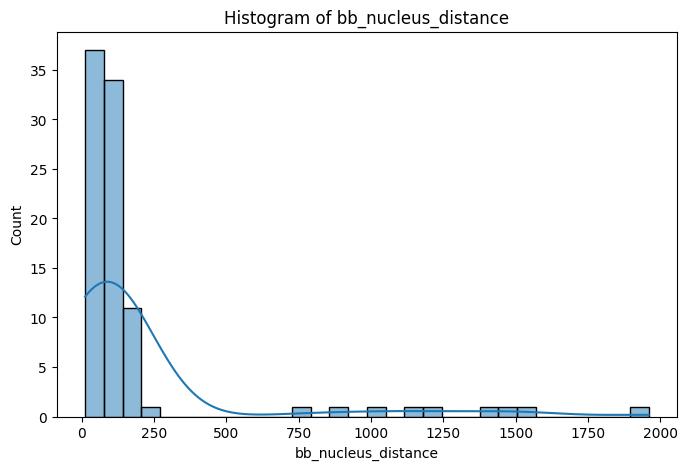

In [ ]:
# Plot a histogram of distance assignments to see how many distances are too long (above the threshold value set in MAX_DIST_NNUCLEI_CILIA) (meaning no good matching )
plt.figure(figsize=(8, 5))
sns.histplot(data=GMNN_predict, x="bb_nucleus_distance", bins=30, kde=True)
plt.title("Histogram of bb_nucleus_distance")
plt.xlabel("bb_nucleus_distance")
plt.ylabel("Count")
plt.show()
plt.close()

In [ ]:
# Drawing assignments into images (for QC)

# For each unique img_index, load the corresponding image and draw lines from (bb_x, bb_y) to (x, y)
# for each row, and save the result as "<img_index>_assignment.jpg" 

dot_radius = 3
offset_x = dot_radius + 2
offset_y = dot_radius + 2

# Group rows by img_index 
for img_index, group in GMNN_predict.groupby("img_index"): 
    img = Image.new("RGB", (2048, 2048), "black")

    # Open the existing PNG as the background (if available)
    png_path = os.path.join(datapath,"InputFiles","Images",img_index + "_new_stack","_inputs.png")

    # Check that the file exists, then open, if not create empty image
    if not os.path.isfile(png_path): 
        print(f"Could not find {png_path}, use black image.") 
        # Create an empty 2048x2048 image (black background)
        img = Image.new("RGB", (2048, 2048), "black")
        #continue
    else:
        img = Image.open(png_path).convert("RGB")
    
    # Create drawing context on this image
    draw = ImageDraw.Draw(img)

    # Draw coordinates and connection for each row in this group 
    for _, row in group.iterrows(): 
        bb_x, bb_y = row["CILIAQ_bb_x"], row["CILIAQ_bb_y"]
        x_val, y_val = row["GMNN_x"], row["GMNN_y"] 
        
        # Draw a line between bb and nucleus and color it red if the assignment distance is too long
        if(row["bb_nucleus_distance"] >= MAX_DIST_NNUCLEI_CILIA):
            draw.line((bb_x, bb_y, x_val, y_val), fill="red", width=1)
        else:
            draw.line((bb_x, bb_y, x_val, y_val), fill="white", width=1)

        # Draw BB center and color it magenta if the BB has no cilium
        if(pd.isna((row["CILIAQ_x center [micron]"]))):
            x0 = bb_x - dot_radius 
            y0 = bb_y - dot_radius
            x1 = bb_x + dot_radius
            y1 = bb_y + dot_radius
            draw.ellipse((x0, y0, x1, y1), fill="magenta")
        else:
            x0 = bb_x - dot_radius - 2
            y0 = bb_y - dot_radius - 2
            x1 = bb_x + dot_radius + 2
            y1 = bb_y + dot_radius + 2
            draw.ellipse((x0, y0, x1, y1), fill="yellow")
        
        # Write BB coordinates next to the center
        draw.text( (bb_x + offset_x + 5, bb_y + offset_y + 5),
                    f"({bb_x:.1f},{bb_y:.1f})",
                    fill="magenta"
                    )
                    
        # Draw Nucleus center
        x0 = x_val - dot_radius 
        y0 = y_val - dot_radius
        x1 = x_val + dot_radius
        y1 = y_val + dot_radius
        draw.ellipse((x0, y0, x1, y1), fill="cyan")
        
        # Write nucleus coordinates next to the center
        draw.text( (x_val + offset_x, y_val + offset_y),
                    f"({x_val:.1f},{y_val:.1f})",
                    fill="cyan"
                    )

        # Save the image under "<img_index>_assignment.jpg"
        out_path =  os.path.join(datapath, gene + "_pred_results", f"{img_index}_assignment.jpg")
        img.save(out_path, "JPEG")

In [ ]:
# Normalize GMNN intensity using a percentile normalization
perc = 0.99
percText = "" + str(perc).replace("0.", "") + "p"
lower_p = GMNN_predict["GMNN_intensity"].quantile(1-perc)
upper_p = GMNN_predict["GMNN_intensity"].quantile(perc)

print('Lower percentile GMNN:' + str(lower_p))
print('Lower percentile GMNN:' + str(upper_p))

# Create a new column "norm_predicted_GMNN" by linear normalization using the percentile values
GMNN_predict["norm_predicted_GMNN_"+percText] = (GMNN_predict["GMNN_intensity"] - lower_p) / (upper_p - lower_p)

Lower percentile GMNN:42.49526448335496
Lower percentile GMNN:76.13212475937702


In [ ]:
# Bin the normalized GMNN intensity values into four categories
bins = [-np.inf, 0.25, 0.5, 0.75, np.inf]
labels = ["<0.25", "0.25-0.5", "0.5-0.75", ">0.75"]
GMNN_predict["binned_norm_GMNN_"+percText] = pd.cut(GMNN_predict["norm_predicted_GMNN_"+percText], bins=bins, labels=labels)

In [ ]:
# Writing the binned normalized GMNN intensity into an image at the nucleus coordinate (for inspection)
for img_index, group in GMNN_predict.groupby("img_index"): 
    img = Image.new("RGB", (2048, 2048), "black")
    
    # Create a drawing context on this image
    draw = ImageDraw.Draw(img)

    # Draw coordinates and connection for each row in this group 
    for _, row in group.iterrows(): 
        x_val, y_val = row["GMNN_x"], row["GMNN_y"] 
                            
        # Draw Nucleus center
        x0 = x_val - dot_radius 
        y0 = y_val - dot_radius
        x1 = x_val + dot_radius
        y1 = y_val + dot_radius
        draw.ellipse((x0, y0, x1, y1), fill="cyan")
        
        draw.text( (x_val + offset_x, y_val + offset_y),
                    row['binned_norm_GMNN_'+percText] + " (" + str(row['norm_predicted_GMNN_'+percText]) + ")",
                    fill="cyan")

        # Save the image under "<img_index>_assignment.jpg"
        out_path =  os.path.join(datapath, gene + "_pred_results", f"{img_index}_PredGMNN_ONLY.jpg")
        img.save(out_path, "JPEG")

In [ ]:
# Filter out the assignments that are too long (exceed the distance threshold MAX_DIST_NNUCLEI_CILIA)
print('Number of cells before removing assignments that are too long: ' + str(len(GMNN_predict["GMNN_x"])))

GMNN_predict = GMNN_predict[GMNN_predict["bb_nucleus_distance"] < MAX_DIST_NNUCLEI_CILIA]

print('Number of remaining cells after removing assignments that are too long: ' + str(len(GMNN_predict["GMNN_x"])))

Number of cells before removing assignments that are too long: 92
Number of remaining cells after removing assignments that are too long: 83


In [ ]:
# Drop all basal bodies in CiliaQ that have no cilia for further plotting
GMNN_predict = GMNN_predict.dropna(subset=["CILIAQ_x center [micron]"])

print('Number of remaining cells after dropping all basal bodies without cilia: ' + str(len(GMNN_predict["GMNN_x"])))

Number of remaining cells after dropping all basal bodies without cilia: 19


In [ ]:
GMNN_predict.to_excel(os.path.join(datapath, gene + "_pred_results", gene + "_assigned_data.xlsx"), index=False)

In [ ]:
# Normalize cilia intensity

param = 'CILIAQ_Average A intensity on center line'
paramAltName = f"Ciliary {gene} average centerline intensity"
paramAltFilenameName = 'CiliaCenterlineAvg'

lower_p = GMNN_predict[param].quantile(1-perc)
upper_p = GMNN_predict[param].quantile(perc)

print('Lower percentile ' + gene + ": " + str(lower_p))
print('Lower percentile ' + gene + ": " + str(upper_p))

# Create a new column "norm_predicted_GMNN" by linear normalization
GMNN_predict["norm_CILIAQ_AvgAIntCntLn"] = (GMNN_predict[param] - lower_p) / (upper_p - lower_p)

Lower percentile CKAP2: 174.50256430000002
Lower percentile CKAP2: 18714.483663560004


In [ ]:
# Statistical testing
print('Statistics for ' + gene + ':')

# Overall nonparametric test: Kruskal-Wallis 
# - Checks if there's a statistically significant difference among all bins
groups = [group_df['norm_CILIAQ_AvgAIntCntLn'].dropna() for _, group_df in GMNN_predict.groupby("binned_norm_GMNN_"+percText, observed=False)]
if len(groups) > 1: # Ensure that we have multiple groups 
    H, p_overall = kruskal(*groups)
    print(f"Kruskal-Wallis result for {gene}: H={H:.3f}, p={p_overall:.3e}")

# Post-hoc pairwise testing using Dunn’s (adjust p-values)
# scikit-posthocs returns matrix of p-values for each group comparison
try:
    dunn_results = sp.posthoc_dunn( GMNN_predict, val_col='norm_CILIAQ_AvgAIntCntLn', group_col="binned_norm_GMNN_"+percText, p_adjust="bonferroni" )
    print("Pairwise Dunn’s test p-values:\n", dunn_results)
except Exception as e: 
    print(f"An error occurred when performing Dunn’s test: {e}")

Statistics for CKAP2:
Kruskal-Wallis result for CKAP2: H=nan, p=nan
Pairwise Dunn’s test p-values:
              <0.25  0.25-0.5  0.5-0.75
<0.25     1.000000  1.000000  0.191069
0.25-0.5  1.000000  1.000000  0.214516
0.5-0.75  0.191069  0.214516  1.000000


P value annotation for plot: {('0.25-0.5', '0.5-0.75'): 0.21451624933462338, ('0.25-0.5', '<0.25'): 1.0, ('0.5-0.75', '<0.25'): 0.19106932540988603}


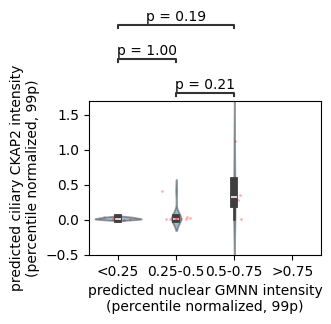

In [ ]:
# Plotting violin plot with overlaying strip plot

plt.figure(figsize=(3, 2))

# Violinplot     
ax = sns.violinplot( data=GMNN_predict, x="binned_norm_GMNN_"+percText, 
            y="norm_CILIAQ_AvgAIntCntLn",
            # cut=0, # By default, extends beyond extreme values; cut=0 keeps it within observed data range
            alpha = 0.5)

# Strip plot
sns.stripplot(data=GMNN_predict, 
            x="binned_norm_GMNN_"+percText,
            y="norm_CILIAQ_AvgAIntCntLn", color="red", alpha=0.3, size=2,jitter=0.25)
    
plt.xlabel("predicted nuclear GMNN intensity\n(percentile normalized, " + percText + ")")
plt.ylabel("predicted ciliary " + gene + " intensity\n(percentile normalized, " + percText + ")")
plt.ylim(-0.5,1.7)

# Annotate significance on the plot with statannotations
# 1) create labels
group_labels = sorted(GMNN_predict["binned_norm_GMNN_"+percText].unique())

pairs = []
for i in range(len(group_labels)):
    for j in range(i+1, len(group_labels)):
        pairs.append((group_labels[i], group_labels[j]))

# 2) Convert the pivot table of p-values to a dictionary:
p_values = {}
for i, g1 in enumerate(group_labels):
    for j, g2 in enumerate(group_labels): 
        if j <= i:  # Avoid repeating diagonal or lower half 
            continue
        p_val = dunn_results.loc[g1, g2]
        p_values[(g1, g2)] = p_val

print('P value annotation for plot: ' + str(p_values))

# Add annotations
annotator = Annotator(ax, pairs, data=GMNN_predict, x="binned_norm_GMNN_"+percText, y="norm_CILIAQ_AvgAIntCntLn")

# Here we will use the p-values we already have, instead of having statannotations compute them
annotator.configure( test=None, # None since we already have p-values
                    text_format="simple", # Options: star, simple, full
                    loc="outside", verbose=False )
annotator.set_pvalues_and_annotate([p_values[pair] for pair in pairs])

violinplot_path = os.path.join(datapath, gene + "_pred_results", gene + "_" + paramAltFilenameName + "_violin_norm_" + percText + "_stats")
plt.savefig(violinplot_path + ".png", dpi=300, bbox_inches="tight")
plt.savefig(violinplot_path + ".svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()